In [7]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import re


In [29]:
movies = pd.read_csv('/home/manishn/recommend/data/ml-latest-small/movies.csv')
ratings= pd.read_csv('/home/manishn/recommend/data/ml-latest-small/ratings.csv')



In [30]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [31]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [32]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")


Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


/tmp/ipykernel_3630740/943713701.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=ratings, palette="viridis")


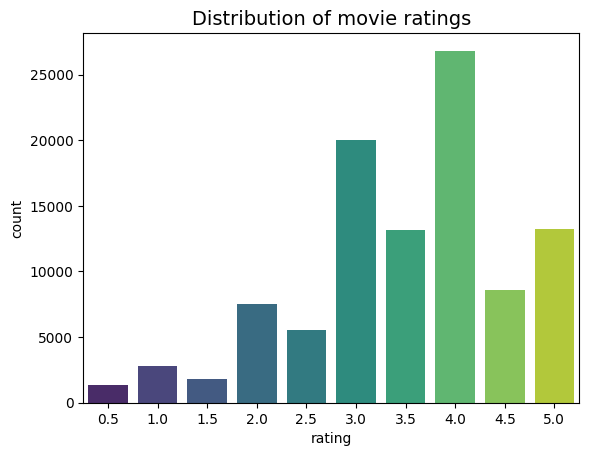

In [33]:
import seaborn as sns
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()


In [34]:
ratings.groupby('userId')['rating'].mean()


userId
1      4.366379
2      3.948276
3      2.435897
4      3.555556
5      3.636364
         ...   
606    3.657399
607    3.786096
608    3.134176
609    3.270270
610    3.688556
Name: rating, Length: 610, dtype: float64

In [35]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")


Mean global rating: 3.5.
Mean rating per user: 3.66.


In [36]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]


title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: count, dtype: int64

In [37]:
movie_ratings

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller


In [38]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId']==lowest_rated]


,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [39]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]


,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [40]:
ratings[ratings['movieId']==highest_rated]


,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


In [41]:

c = ratings[ratings['movieId'] == 53]['rating']
c

13368    5.0
96115    5.0
Name: rating, dtype: float64

In [42]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [43]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.head()


,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [44]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)


Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


In [45]:
lamerica = pd.Series([5, 5])
lamerica

0    5
1    5
dtype: int64

In [46]:
lamerica = pd.Series([5, 5])
bayesian_avg(lamerica)


3.543

In [47]:
# bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
# bayesian_avg_ratings

In [48]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')
movie_stats

,movieId,count,mean,bayesian_avg
0,1,215,3.920930,3.891
1,2,110,3.431818,3.417
2,3,52,3.259615,3.260
3,4,7,2.357143,2.898
4,5,49,3.071429,3.105
...,...,...,...,...
9719,193581,1,4.000000,3.327
9720,193583,1,3.500000,3.283
9721,193585,1,3.500000,3.283
9722,193587,1,3.500000,3.283


In [49]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()


,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"


In [50]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()


,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [57]:
print(list(g for genres in movies['genres'] for g in genres)[:11])


['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Adventure', 'Children', 'Fantasy', 'Comedy', 'Romance', 'Comedy']


In [58]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency


There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [68]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
# genre_frequency_df.columns = ['genre', 'count']
genre_frequency_df

,index,0
0,Adventure,1263
1,Animation,611
2,Children,664
3,Comedy,3756
4,Fantasy,779
5,Romance,1596
6,Drama,4361
7,Action,1828
8,Crime,1199
9,Thriller,1894


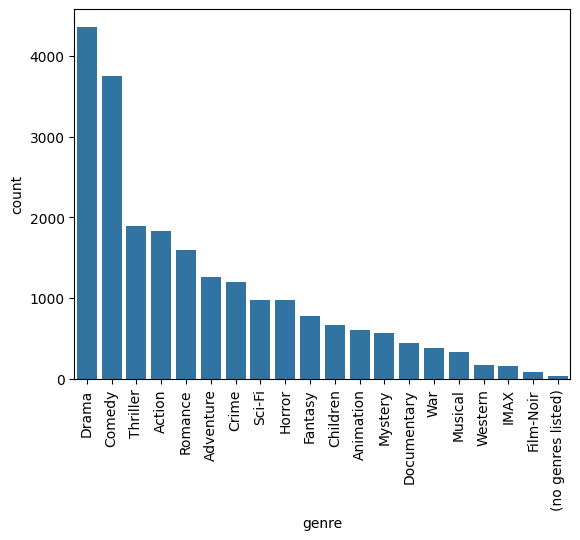

In [69]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()

In [70]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)


In [71]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids


In [72]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)

movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])


Because you watched Toy Story (1995):
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)


In [73]:
import numpy as np

def predictMissingRatings(Y, R, U, V):
    """
    Predict missing ratings in the user-item interaction matrix.

    Parameters
    ----------
    Y: numpy array-like
        User-item interaction matrix of shape (m, n) where m = users, n = movies
    R: numpy array-like
        Binary-valued indicator matrix of shape (m, n) indicating whether a rating is present (1) or not (0)
    U: numpy array-like
        User feature matrix of shape (m, k) where k is the number of features
    V: numpy array-like
        Item feature matrix of shape (n, k) where k is the number of features

    Returns
    -------
    Y_pred: numpy array-like
        Matrix of predicted ratings with the same shape as Y, where missing ratings are filled in
    """
    # Calculate predicted ratings by multiplying U and V
    Y_pred = np.dot(U, V.T)  # This gives the predicted ratings for all users and items

    # Replace missing ratings (where R is 0) in the original Y with the predicted ratings
    Y_filled = Y.copy()  # Create a copy of Y to fill in the predicted ratings
    Y_filled[R == 0] = Y_pred[R == 0]  # Only fill in the missing ratings

    return Y_filled



[[4 0 0]
 [0 5 0]
 [0 0 3]]


In [7]:
# Load the Netflix dataset
netflix_data = pd.read_csv("E:/honeywell assignment/netflix_titles.csv")

# Select relevant columns for the recommendation system
netflix_data = netflix_data[['title', 'description', 'rating', 'duration', 'listed_in']]

# Handle missing values by removing rows with NA descriptions
netflix_data = netflix_data.dropna(subset=['description'])

# Preprocess the description: Convert to lowercase and remove punctuation
netflix_data['clean_description'] = netflix_data['description'].str.lower()+' ' +netflix_data['listed_in'].str.lower()
netflix_data['clean_description'] = netflix_data['clean_description'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [13]:
netflix_data

,title,description,rating,duration,listed_in,clean_description
0,Dick Johnson Is Dead,"As her father nears the end of his life, filmm...",PG-13,90 min,Documentaries,as her father nears the end of his life filmma...
1,Blood & Water,"After crossing paths at a party, a Cape Town t...",TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries",after crossing paths at a party a cape town te...
2,Ganglands,To protect his family from a powerful drug lor...,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",to protect his family from a powerful drug lor...
3,Jailbirds New Orleans,"Feuds, flirtations and toilet talk go down amo...",TV-MA,1 Season,"Docuseries, Reality TV",feuds flirtations and toilet talk go down amon...
4,Kota Factory,In a city of coaching centers known to train I...,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",in a city of coaching centers known to train i...
...,...,...,...,...,...,...
8802,Zodiac,"A political cartoonist, a crime reporter and a...",R,158 min,"Cult Movies, Dramas, Thrillers",a political cartoonist a crime reporter and a ...
8803,Zombie Dumb,"While living alone in a spooky town, a young g...",TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies",while living alone in a spooky town a young gi...
8804,Zombieland,Looking to survive in a world taken over by zo...,R,88 min,"Comedies, Horror Movies",looking to survive in a world taken over by zo...
8805,Zoom,"Dragged from civilian life, a former superhero...",PG,88 min,"Children & Family Movies, Comedies",dragged from civilian life a former superhero ...


In [14]:
# Load a pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to recommend movies based on description similarity using sentence transformers
def recommend_based_on_description(movie_title, data, model, num_recommendations=5):
    # Find the index of the movie
    movie_index = data.index[data['title'] == movie_title].tolist()
    
    if not movie_index:
        raise ValueError("Movie not found!")
    
    movie_index = movie_index[0]

    # Generate embeddings for all movie descriptions
    embeddings = model.encode(data['clean_description'].tolist(), show_progress_bar=True)
    
    # Calculate cosine similarity between the target movie and all others
    cosine_sim = cosine_similarity([embeddings[movie_index]], embeddings).flatten()
    
    # Get the indices of the most similar movies (excluding the target movie itself)
    sim_scores = list(enumerate(cosine_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[0:num_recommendations+1]  # Exclude the first result (the movie itself)
    
    # Get the indices of the recommended movies
    movie_indices = [i[0] for i in sim_scores]
    
    # Return the titles of the recommended movies
    return data['title'].iloc[movie_indices].tolist(),sim_scores

c:\Users\user\miniconda3\envs\DataAnalytics\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:

# Example: Get recommendations for a specific movie
movie_title = "The Irishman"
description_recommendations,_ = recommend_based_on_description(movie_title, netflix_data, model, 5)



Batches: 100%|██████████| 276/276 [01:04<00:00,  4.25it/s]


In [16]:
# Print recommendations
print(f"Movies similar to {movie_title}:")
for movie in description_recommendations:
    print(movie)

Movies similar to The Irishman:
The Irishman
Pulp Fiction
All Day and a Night
Küçük Esnaf
The Blue Elephant 2
RattleSnake - The Ahanna Story


***Using Tfidf vectoriser***

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

def recommend_based_on_description(movie_title, data, num_recommendations=5):
    movie_index = data.index[data['title'] == movie_title].tolist()
    
    if not movie_index:
        raise ValueError("Movie not found!")
    
    movie_index = movie_index[0]
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(data['clean_description'])
    cosine_sim = cosine_similarity(tfidf_matrix[movie_index], tfidf_matrix).flatten()
    sim_scores = list(enumerate(cosine_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[0:num_recommendations+1]  # Exclude the first result (the movie itself)
    
    # Get the indices of the recommended movies
    movie_indices = [i[0] for i in sim_scores]
    
    # Return the titles of the recommended movies
    return data['title'].iloc[movie_indices].tolist()

# Example: Get recommendations for a specific movie
movie_title = "The Irishman"
description_recommendations = recommend_based_on_description(movie_title, netflix_data, 5)

# Print recommendations
print(f"Movies similar to {movie_title}:")
for movie in description_recommendations:
    print(movie)


Movies similar to The Irishman:
The Irishman
Rolling Thunder Revue: A Bob Dylan Story by Martin Scorsese
All Day and a Night
Why We Fight: The Battle of Russia
Catch Me If You Can
Pretend It’s a City


**Using KNN for Reccomendation**


In [17]:
from sklearn.neighbors import NearestNeighbors
model = SentenceTransformer('all-MiniLM-L6-v2')
def recommend_with_knn(movie_title, data, model, num_recommendations=5):
    movie_index = data.index[data['title'] == movie_title].tolist()
    if not movie_index:
        raise ValueError("Movie not found!")
    movie_index = movie_index[0]
    embeddings = model.encode(data['clean_description'].tolist(), show_progress_bar=True)
    knn = NearestNeighbors(n_neighbors=num_recommendations + 1, metric='cosine')
    knn.fit(embeddings)
    distances, indices = knn.kneighbors([embeddings[movie_index]])
    recommended_indices = indices.flatten()[1:]  # Skip the first result (the movie itself)
    recommended_distances = distances.flatten()[1:]

    return data['title'].iloc[recommended_indices].tolist(), recommended_distances


c:\Users\user\miniconda3\envs\DataAnalytics\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [19]:
# Example: Get recommendations for a specific movie
movie_title = "The Irishman"
description_recommendations,_ = recommend_with_knn(movie_title, netflix_data,model, 5)

# Print recommendations
print(f"Movies similar to {movie_title}:")
for movie in description_recommendations:
    print(movie)


Batches: 100%|██████████| 276/276 [01:09<00:00,  3.97it/s]

Movies similar to The Irishman:
Pulp Fiction
All Day and a Night
Küçük Esnaf
The Blue Elephant 2
RattleSnake - The Ahanna Story
